In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
v0_data_dir = '../data/test_files_v0'
# v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
# filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label not in categories.keys() : 
#         categories[label] = 0
#     categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 103
randomness 17
time 42
network 31
platform dependency 2
resource leak 10
async wait 125
test case timeout 14
concurrency 48
unordered collections 51
floating point operations 3
too restrictive range 3
i_o 2


In [4]:
import random
from sklearn.model_selection import train_test_split

buggy_code = []
filenames = []
label_counts = {
    'async wait': 0,
    'unordered collections': 0,
    'concurrency': 0,
    'time': 0,
    'test order dependency': 0
}

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower()
    if label in label_counts:
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
            label_counts[label] += 1

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower()
#     if label in label_counts:
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#             label_counts[label] += 1

# Print the categories and their corresponding number before train-test split
print("------------before limiting--------------")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Separate block for limiting the number of data points per category
max_data_points = {
    'async wait': 42,  # specify the number you want for each category
    'unordered collections': 42,
    'concurrency': 42,
    'time': 42,
    'test order dependency': 42
}

filtered_buggy_code = []
filtered_filenames = []
filtered_label_counts = {
    'async wait': 0,
    'unordered collections': 0,
    'concurrency': 0,
    'time': 0,
    'test order dependency': 0
}

# Shuffle the indices with a consistent seed
random.seed(42)
indices = list(range(len(buggy_code)))
random.shuffle(indices)

# Select data points while respecting the max_data_points limit
for i in indices:
    label = (filenames[i].split("@")[1]).split('.')[0].strip().lower()
    if label in filtered_label_counts and filtered_label_counts[label] < max_data_points[label]:
        filtered_buggy_code.append(buggy_code[i])
        filtered_filenames.append(filenames[i])
        filtered_label_counts[label] += 1

# Print the filtered categories and their corresponding number before train-test split
print("------------after limiting--------------")
for label, count in filtered_label_counts.items():
    print(f"{label}: {count}")

train_buggy_code, valid_buggy_code = train_test_split(filtered_buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filtered_filenames, test_size=0.2, random_state=42)


------------before limiting--------------
async wait: 125
unordered collections: 51
concurrency: 48
time: 42
test order dependency: 103
------------after limiting--------------
async wait: 42
unordered collections: 42
concurrency: 42
time: 42
test order dependency: 42


In [5]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 2591
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            if total_length >= self.max_len:
                self.max_len = total_length
                print(self.max_len)
        
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [7]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])


  2%|▏         | 3/168 [00:00<00:16, 10.22it/s]

548
1330
1902


  5%|▍         | 8/168 [00:00<00:09, 16.26it/s]

1902
2270


 25%|██▌       | 42/168 [00:01<00:05, 22.33it/s]

2270


 36%|███▋      | 61/168 [00:02<00:04, 24.69it/s]

2270
2270


 40%|███▉      | 67/168 [00:03<00:04, 21.38it/s]

2591
2591


 71%|███████▏  | 120/168 [00:04<00:01, 26.28it/s]

2591


100%|██████████| 168/168 [00:06<00:00, 25.28it/s]


In [10]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [11]:
m_len

2591

In [12]:
max_length

2591

In [13]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid'] 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [14]:
# !python3 -m pip install matplotlib==3.5.2

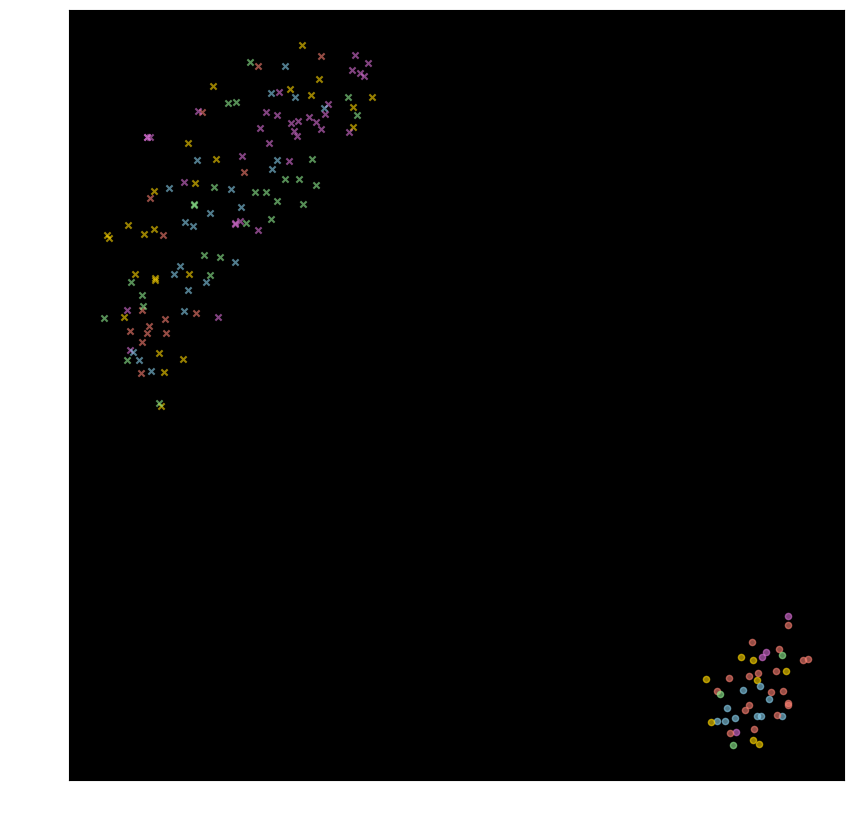

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


In [16]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch
# from sklearn.preprocessing import MinMaxScaler

# X = torch.stack(plot_data).cpu().numpy()
# labelsNums = plot_labels

# # Perform t-SNE dimensionality reduction
# X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# # Normalize the points
# scaler = MinMaxScaler()
# X_embedded_normalized = scaler.fit_transform(X_embedded)

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# for i in range(len(X_embedded_normalized)):
#     marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
#     plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# # Set the background color to black
# plt.gca().set_facecolor('black')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')

# plt.show()


In [17]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [18]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [19]:
learning_rate = 5e-6
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [20]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [45]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 200
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter('logs/flakyXbert_300_seed123456')
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.01
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert_TImeConc_v1.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

  5%|▍         | 1/21 [00:00<00:07,  2.66it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:03,  4.10it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.37it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  2.91it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.01it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.30it/s]


Epoch 1/200, Loss: 0.24378696129435584


  5%|▍         | 1/21 [00:00<00:05,  3.74it/s]

Loss improved saving model


 90%|█████████ | 19/21 [00:04<00:00,  4.13it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 2/200, Loss: 0.2701484664848873


  5%|▍         | 1/21 [00:00<00:07,  2.85it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:05,  3.48it/s]

Loss improved saving model


 48%|████▊     | 10/21 [00:02<00:02,  4.39it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.07it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


Epoch 3/200, Loss: 0.26783760327668416


  5%|▍         | 1/21 [00:00<00:09,  2.17it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:03,  3.36it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 4/200, Loss: 0.2899661210605076


 14%|█▍        | 3/21 [00:01<00:07,  2.51it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.37it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.13it/s]


Epoch 5/200, Loss: 0.2694421088695526


 38%|███▊      | 8/21 [00:01<00:02,  4.65it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:02,  3.00it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.27it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 6/200, Loss: 0.1863038058366094


 14%|█▍        | 3/21 [00:00<00:04,  4.26it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  3.88it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  2.56it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  2.49it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


Epoch 7/200, Loss: 0.2774250543827102


  5%|▍         | 1/21 [00:00<00:05,  3.42it/s]

Loss improved saving model
2591


 33%|███▎      | 7/21 [00:01<00:03,  3.64it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.83it/s]


Epoch 8/200, Loss: 0.2690001528461774


 81%|████████  | 17/21 [00:05<00:01,  2.73it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


Epoch 9/200, Loss: 0.20260343071960266


  0%|          | 0/21 [00:00<?, ?it/s]

2591


  5%|▍         | 1/21 [00:00<00:08,  2.28it/s]

2591


 24%|██▍       | 5/21 [00:01<00:03,  4.52it/s]

2591


 29%|██▊       | 6/21 [00:01<00:04,  3.67it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.44it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.27it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 10/200, Loss: 0.1794717465412049


 71%|███████▏  | 15/21 [00:04<00:01,  3.04it/s]

2591


 81%|████████  | 17/21 [00:04<00:01,  3.20it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 11/200, Loss: 0.22290014059770674


 24%|██▍       | 5/21 [00:01<00:05,  2.83it/s]

2591


 33%|███▎      | 7/21 [00:02<00:03,  4.02it/s]

2591


 38%|███▊      | 8/21 [00:02<00:04,  3.24it/s]

2591


 43%|████▎     | 9/21 [00:02<00:04,  2.79it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.10it/s]


Epoch 12/200, Loss: 0.27391193639664424


 14%|█▍        | 3/21 [00:00<00:05,  3.24it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


Epoch 13/200, Loss: 0.21545283328919182


 19%|█▉        | 4/21 [00:00<00:03,  4.97it/s]

2591


 86%|████████▌ | 18/21 [00:04<00:00,  3.72it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 14/200, Loss: 0.2599083970274244


  5%|▍         | 1/21 [00:00<00:06,  3.29it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  2.71it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 15/200, Loss: 0.23912526570615314


  5%|▍         | 1/21 [00:00<00:06,  3.21it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  4.04it/s]

2591


 19%|█▉        | 4/21 [00:01<00:06,  2.48it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:01,  3.72it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.61it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


Epoch 16/200, Loss: 0.25477001471178873


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 14%|█▍        | 3/21 [00:00<00:05,  3.58it/s]

2591


 33%|███▎      | 7/21 [00:01<00:03,  4.31it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.49it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.62it/s]


Epoch 17/200, Loss: 0.24597851267882756


 48%|████▊     | 10/21 [00:02<00:03,  3.26it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.49it/s]


Epoch 18/200, Loss: 0.22793917084024065


  0%|          | 0/21 [00:00<?, ?it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.60it/s]


Epoch 19/200, Loss: 0.26148654672361554


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:06,  2.85it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:01,  3.75it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.13it/s]


Epoch 20/200, Loss: 0.17153559209335417


 86%|████████▌ | 18/21 [00:05<00:00,  3.97it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 21/200, Loss: 0.17715695652223767


 57%|█████▋    | 12/21 [00:03<00:02,  3.00it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 22/200, Loss: 0.24623613459723334


 10%|▉         | 2/21 [00:00<00:05,  3.28it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.46it/s]

2591


 76%|███████▌  | 16/21 [00:05<00:01,  3.24it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.18it/s]


Epoch 23/200, Loss: 0.2034538878855251


 19%|█▉        | 4/21 [00:00<00:03,  5.24it/s]

2591
2591


 48%|████▊     | 10/21 [00:02<00:03,  3.11it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:03,  2.46it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.17it/s]


Epoch 24/200, Loss: 0.24526030473765872


 14%|█▍        | 3/21 [00:01<00:06,  3.00it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.46it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.38it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.98it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.24it/s]


Epoch 25/200, Loss: 0.26891767562854857


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:05,  3.39it/s]

2591


 33%|███▎      | 7/21 [00:01<00:03,  3.65it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.05it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.23it/s]


Epoch 26/200, Loss: 0.23732946077982583


 19%|█▉        | 4/21 [00:00<00:04,  4.17it/s]

2591


 52%|█████▏    | 11/21 [00:02<00:02,  3.65it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.28it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 27/200, Loss: 0.2150910479965664


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.28it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  4.35it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


Epoch 28/200, Loss: 0.2290372633082526


  5%|▍         | 1/21 [00:00<00:06,  3.02it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.33it/s]


Epoch 29/200, Loss: 0.21707970020316894


 19%|█▉        | 4/21 [00:01<00:05,  2.87it/s]

2591


 86%|████████▌ | 18/21 [00:04<00:00,  3.94it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.27it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


Epoch 30/200, Loss: 0.2425417691753024


  5%|▍         | 1/21 [00:00<00:09,  2.19it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.87it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.46it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.83it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.27it/s]


Epoch 31/200, Loss: 0.268966637296336


 62%|██████▏   | 13/21 [00:04<00:02,  3.21it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.52it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 32/200, Loss: 0.2634286931157112


  5%|▍         | 1/21 [00:00<00:05,  3.64it/s]

2591


 81%|████████  | 17/21 [00:04<00:01,  3.12it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


Epoch 33/200, Loss: 0.1877769992039317


 19%|█▉        | 4/21 [00:01<00:05,  3.19it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.84it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:03,  3.31it/s]

2591


 62%|██████▏   | 13/21 [00:04<00:02,  3.30it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 34/200, Loss: 0.20322768683944428


 62%|██████▏   | 13/21 [00:03<00:02,  3.58it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.19it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Epoch 35/200, Loss: 0.21513746156578972


 48%|████▊     | 10/21 [00:02<00:02,  4.09it/s]

2591


 52%|█████▏    | 11/21 [00:02<00:02,  3.60it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  3.86it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


Epoch 36/200, Loss: 0.2125316330648604


 14%|█▍        | 3/21 [00:00<00:06,  2.84it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.51it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Epoch 37/200, Loss: 0.23646648841244833


 57%|█████▋    | 12/21 [00:03<00:02,  3.97it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.10it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.70it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


Epoch 38/200, Loss: 0.18566694830145153


 10%|▉         | 2/21 [00:00<00:03,  5.12it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.78it/s]


Epoch 39/200, Loss: 0.3029698716316904


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.28it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.01it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


Epoch 40/200, Loss: 0.1539102747610637


 14%|█▍        | 3/21 [00:00<00:04,  4.49it/s]

2591


 38%|███▊      | 8/21 [00:02<00:04,  3.17it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.89it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


Epoch 41/200, Loss: 0.26845308154821396


 38%|███▊      | 8/21 [00:02<00:03,  3.41it/s]

2591


 48%|████▊     | 10/21 [00:02<00:03,  3.58it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.63it/s]


Epoch 42/200, Loss: 0.1751536646343413


 10%|▉         | 2/21 [00:00<00:04,  4.35it/s]

2591


 33%|███▎      | 7/21 [00:01<00:04,  3.11it/s]

2591


 38%|███▊      | 8/21 [00:02<00:04,  2.83it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.80it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


Epoch 43/200, Loss: 0.19512937015011195


  0%|          | 0/21 [00:00<?, ?it/s]

Loss improved saving model


 24%|██▍       | 5/21 [00:01<00:05,  3.16it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.74it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


2591
Epoch 44/200, Loss: 0.20852463702360788


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  4.05it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


Epoch 45/200, Loss: 0.19726418926602318


 24%|██▍       | 5/21 [00:01<00:04,  3.46it/s]

2591


 29%|██▊       | 6/21 [00:01<00:05,  2.91it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  3.08it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.43it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


Epoch 46/200, Loss: 0.16986476036764325


 67%|██████▋   | 14/21 [00:03<00:02,  3.26it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.77it/s]


Epoch 47/200, Loss: 0.1741736993477458


 10%|▉         | 2/21 [00:00<00:04,  4.03it/s]

2591


 19%|█▉        | 4/21 [00:01<00:05,  3.25it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


Epoch 48/200, Loss: 0.16673583440837406


 10%|▉         | 2/21 [00:00<00:07,  2.60it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.73it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.16it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.04it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.40it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:01,  2.98it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.21it/s]


Epoch 49/200, Loss: 0.20734285324811935


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:07,  2.38it/s]

2591


 14%|█▍        | 3/21 [00:01<00:07,  2.51it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.21it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.24it/s]


Epoch 50/200, Loss: 0.2241437244557199


 19%|█▉        | 4/21 [00:01<00:04,  3.73it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Epoch 51/200, Loss: 0.283290021220843


  5%|▍         | 1/21 [00:00<00:09,  2.05it/s]

Loss improved saving model


 24%|██▍       | 5/21 [00:01<00:04,  3.53it/s]

2591


 90%|█████████ | 19/21 [00:06<00:00,  3.22it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.02it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.03it/s]


Epoch 52/200, Loss: 0.1662520206684158


 24%|██▍       | 5/21 [00:01<00:04,  3.68it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  2.91it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.26it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.08it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Epoch 53/200, Loss: 0.1979929504224232


 43%|████▎     | 9/21 [00:02<00:02,  4.09it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.49it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.07it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


Epoch 54/200, Loss: 0.13560426635401587


 71%|███████▏  | 15/21 [00:03<00:01,  5.05it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.60it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 55/200, Loss: 0.24378293833562306


  5%|▍         | 1/21 [00:00<00:06,  2.94it/s]

Loss improved saving model


 95%|█████████▌| 20/21 [00:05<00:00,  3.92it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.56it/s]


Epoch 56/200, Loss: 0.13684549192587533


 24%|██▍       | 5/21 [00:01<00:05,  3.09it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  4.44it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


2591
Epoch 57/200, Loss: 0.17818098560685203


 86%|████████▌ | 18/21 [00:05<00:00,  3.40it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.18it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


2591
Epoch 58/200, Loss: 0.1684723210050946


 24%|██▍       | 5/21 [00:01<00:04,  3.86it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.23it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.65it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Epoch 59/200, Loss: 0.22431831887790135


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:07,  2.58it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


Epoch 60/200, Loss: 0.21938016985143932


  5%|▍         | 1/21 [00:00<00:04,  4.45it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.62it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.15it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.10it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 61/200, Loss: 0.1960653255667005


 52%|█████▏    | 11/21 [00:03<00:03,  2.75it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.87it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


Epoch 62/200, Loss: 0.15773781505369003


  5%|▍         | 1/21 [00:00<00:04,  4.31it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:02,  2.93it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 63/200, Loss: 0.1356601212280137


  5%|▍         | 1/21 [00:00<00:06,  2.88it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  3.80it/s]

Loss improved saving model
2591


 33%|███▎      | 7/21 [00:01<00:03,  3.52it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.57it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.14it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


2591
Epoch 64/200, Loss: 0.1805239143399965


 14%|█▍        | 3/21 [00:00<00:04,  3.85it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.13it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  2.88it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.22it/s]


Epoch 65/200, Loss: 0.15642490673632847


  5%|▍         | 1/21 [00:00<00:06,  3.15it/s]

2591


 24%|██▍       | 5/21 [00:02<00:06,  2.35it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.47it/s]


Epoch 66/200, Loss: 0.1890906649969873


  5%|▍         | 1/21 [00:00<00:05,  3.93it/s]

2591


 10%|▉         | 2/21 [00:00<00:06,  2.72it/s]

2591


 29%|██▊       | 6/21 [00:01<00:04,  3.31it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.24it/s]


Epoch 67/200, Loss: 0.17940910525265194


 71%|███████▏  | 15/21 [00:03<00:01,  3.46it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


Epoch 68/200, Loss: 0.1490706781120527


 24%|██▍       | 5/21 [00:01<00:05,  3.13it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.55it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.73it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


Epoch 69/200, Loss: 0.20943324739024752


 24%|██▍       | 5/21 [00:01<00:03,  4.25it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Epoch 70/200, Loss: 0.19692658430054072


 19%|█▉        | 4/21 [00:00<00:04,  3.91it/s]

2591


 43%|████▎     | 9/21 [00:02<00:04,  2.70it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.14it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.63it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.25it/s]


Epoch 71/200, Loss: 0.1978363204144296


  5%|▍         | 1/21 [00:00<00:04,  4.33it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:05,  3.71it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.62it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


Epoch 72/200, Loss: 0.1393590045401028


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 43%|████▎     | 9/21 [00:02<00:04,  2.84it/s]

2591
2591


 76%|███████▌  | 16/21 [00:05<00:01,  2.92it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.21it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.15it/s]


Epoch 73/200, Loss: 0.18337919182720638


 67%|██████▋   | 14/21 [00:04<00:02,  3.05it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.68it/s]


Epoch 74/200, Loss: 0.24821209988423756


  5%|▍         | 1/21 [00:00<00:07,  2.59it/s]

2591


 10%|▉         | 2/21 [00:00<00:06,  2.98it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.35it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.51it/s]


Epoch 75/200, Loss: 0.1379741761230287


 10%|▉         | 2/21 [00:00<00:04,  3.97it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:01,  2.91it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.16it/s]


Epoch 76/200, Loss: 0.14824901140871502


 14%|█▍        | 3/21 [00:00<00:04,  4.13it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.27it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.50it/s]


Epoch 77/200, Loss: 0.15858762756699607


 57%|█████▋    | 12/21 [00:03<00:02,  3.80it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.47it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 78/200, Loss: 0.13974489281574884


 33%|███▎      | 7/21 [00:01<00:02,  5.39it/s]

2591


 52%|█████▏    | 11/21 [00:02<00:02,  4.24it/s]

2591


 81%|████████  | 17/21 [00:04<00:01,  3.90it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


Epoch 79/200, Loss: 0.15115573870284216


 43%|████▎     | 9/21 [00:02<00:03,  3.50it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.69it/s]


Epoch 80/200, Loss: 0.15330182558014277


  5%|▍         | 1/21 [00:00<00:04,  4.27it/s]

Loss improved saving model
2591
2591


 24%|██▍       | 5/21 [00:01<00:04,  3.53it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  2.84it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 81/200, Loss: 0.13106887726556687


 24%|██▍       | 5/21 [00:01<00:05,  3.07it/s]

2591


 62%|██████▏   | 13/21 [00:04<00:02,  2.97it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.23it/s]


Epoch 82/200, Loss: 0.21367743976059414


 43%|████▎     | 9/21 [00:02<00:02,  4.07it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:03,  2.79it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 83/200, Loss: 0.166214511962164


 67%|██████▋   | 14/21 [00:03<00:02,  3.28it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.49it/s]


Epoch 84/200, Loss: 0.16511484139022373


 24%|██▍       | 5/21 [00:01<00:03,  4.32it/s]

2591


 43%|████▎     | 9/21 [00:02<00:04,  2.97it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.01it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.27it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


Epoch 85/200, Loss: 0.17239991053229287


 86%|████████▌ | 18/21 [00:04<00:00,  3.79it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.72it/s]


Epoch 86/200, Loss: 0.16730593225785664


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 38%|███▊      | 8/21 [00:02<00:04,  2.92it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  4.75it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


Epoch 87/200, Loss: 0.19460649656397955


 14%|█▍        | 3/21 [00:00<00:04,  3.72it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.97it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.56it/s]


Epoch 88/200, Loss: 0.1848518157572973


 19%|█▉        | 4/21 [00:01<00:05,  2.87it/s]

2591


 38%|███▊      | 8/21 [00:02<00:05,  2.49it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.46it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


Epoch 89/200, Loss: 0.2155451786234265


  5%|▍         | 1/21 [00:00<00:04,  4.56it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.55it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.53it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Epoch 90/200, Loss: 0.16896457128581546


 48%|████▊     | 10/21 [00:02<00:03,  3.06it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.05it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 91/200, Loss: 0.16696639049620854


 52%|█████▏    | 11/21 [00:03<00:02,  3.50it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:03,  2.93it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 92/200, Loss: 0.14429913187310808


 10%|▉         | 2/21 [00:00<00:04,  3.81it/s]

Loss improved saving model


 57%|█████▋    | 12/21 [00:03<00:02,  3.31it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  2.71it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 93/200, Loss: 0.14565475827171687


  5%|▍         | 1/21 [00:00<00:05,  3.36it/s]

2591


 19%|█▉        | 4/21 [00:01<00:05,  2.91it/s]

2591
2591


 33%|███▎      | 7/21 [00:02<00:04,  3.35it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.70it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.22it/s]


Epoch 94/200, Loss: 0.20286151244526818


 29%|██▊       | 6/21 [00:01<00:04,  3.36it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:01,  3.64it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 95/200, Loss: 0.16237852448508852


 62%|██████▏   | 13/21 [00:03<00:02,  3.02it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  2.92it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.09it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Epoch 96/200, Loss: 0.1586300611070224


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 24%|██▍       | 5/21 [00:01<00:04,  3.40it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.37it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.63it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.05it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


Epoch 97/200, Loss: 0.14041187801531382


 43%|████▎     | 9/21 [00:02<00:02,  4.14it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.72it/s]


Epoch 98/200, Loss: 0.1263689009490467


 10%|▉         | 2/21 [00:00<00:07,  2.65it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.39it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


Epoch 99/200, Loss: 0.13130791956470125


 14%|█▍        | 3/21 [00:00<00:06,  3.00it/s]

2591


 24%|██▍       | 5/21 [00:01<00:05,  2.95it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


Epoch 100/200, Loss: 0.18371653815110522


  0%|          | 0/21 [00:00<?, ?it/s]

2591


  5%|▍         | 1/21 [00:00<00:09,  2.05it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:06,  2.92it/s]

Loss improved saving model
2591


 14%|█▍        | 3/21 [00:01<00:05,  3.09it/s]

2591


 62%|██████▏   | 13/21 [00:04<00:02,  3.56it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Epoch 101/200, Loss: 0.15864606850204013


 14%|█▍        | 3/21 [00:01<00:07,  2.52it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.08it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  2.31it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.24it/s]


Epoch 102/200, Loss: 0.18350330359878994


  5%|▍         | 1/21 [00:00<00:10,  1.88it/s]

2591


 38%|███▊      | 8/21 [00:02<00:02,  4.41it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.89it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.60it/s]


2591
Epoch 103/200, Loss: 0.1609414316642852


  5%|▍         | 1/21 [00:00<00:04,  4.86it/s]

Loss improved saving model
2591


 14%|█▍        | 3/21 [00:00<00:06,  2.97it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.01it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.77it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.51it/s]


Epoch 104/200, Loss: 0.1546205396737371


 10%|▉         | 2/21 [00:00<00:04,  4.08it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.37it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


Epoch 105/200, Loss: 0.16283074705373674


  5%|▍         | 1/21 [00:00<00:08,  2.30it/s]

2591


 14%|█▍        | 3/21 [00:01<00:05,  3.24it/s]

2591


 33%|███▎      | 7/21 [00:02<00:03,  3.51it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  2.93it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.44it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.27it/s]


Epoch 106/200, Loss: 0.12985852051348912


  5%|▍         | 1/21 [00:00<00:04,  4.04it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  3.85it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:05,  3.08it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.59it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  3.20it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.72it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 107/200, Loss: 0.09816489201216469


 14%|█▍        | 3/21 [00:00<00:04,  3.96it/s]

2591


 48%|████▊     | 10/21 [00:02<00:03,  3.58it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.37it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 108/200, Loss: 0.14577669447376612


 10%|▉         | 2/21 [00:00<00:07,  2.46it/s]

2591
2591


 29%|██▊       | 6/21 [00:02<00:05,  2.62it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.92it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.32it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.28it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.10it/s]


Epoch 109/200, Loss: 0.13690756484156563


 52%|█████▏    | 11/21 [00:03<00:02,  3.51it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.10it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.18it/s]


Epoch 110/200, Loss: 0.16693470282214026


 52%|█████▏    | 11/21 [00:02<00:02,  4.17it/s]

2591


 81%|████████  | 17/21 [00:04<00:01,  3.27it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


Epoch 111/200, Loss: 0.14214824753148214


 29%|██▊       | 6/21 [00:01<00:04,  3.65it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.38it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


Epoch 112/200, Loss: 0.13261749498900913


  0%|          | 0/21 [00:00<?, ?it/s]

2591


  5%|▍         | 1/21 [00:00<00:07,  2.78it/s]

2591


 14%|█▍        | 3/21 [00:00<00:05,  3.08it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.32it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.42it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  2.99it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


Epoch 113/200, Loss: 0.10141143673942202


  5%|▍         | 1/21 [00:00<00:04,  4.13it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  4.24it/s]

Loss improved saving model


 86%|████████▌ | 18/21 [00:04<00:00,  3.41it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


Epoch 114/200, Loss: 0.16214330185027348


 76%|███████▌  | 16/21 [00:04<00:01,  3.56it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  2.73it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 115/200, Loss: 0.10543246754578181


 95%|█████████▌| 20/21 [00:05<00:00,  2.87it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.46it/s]


Epoch 116/200, Loss: 0.08907035251458487


  0%|          | 0/21 [00:00<?, ?it/s]

Loss improved saving model


 43%|████▎     | 9/21 [00:02<00:03,  3.38it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:03,  2.81it/s]

2591
2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.01it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


Epoch 117/200, Loss: 0.1340458131546066


  5%|▍         | 1/21 [00:00<00:04,  4.30it/s]

Loss improved saving model


 57%|█████▋    | 12/21 [00:03<00:02,  3.23it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.96it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.56it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.33it/s]


Epoch 118/200, Loss: 0.10426490231638862


 24%|██▍       | 5/21 [00:01<00:04,  3.54it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


Epoch 119/200, Loss: 0.11691204574846085


  5%|▍         | 1/21 [00:00<00:08,  2.46it/s]

2591


 29%|██▊       | 6/21 [00:02<00:05,  2.59it/s]

2591


 43%|████▎     | 9/21 [00:03<00:03,  3.18it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 120/200, Loss: 0.14210367141734986


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 14%|█▍        | 3/21 [00:00<00:05,  3.25it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.52it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 121/200, Loss: 0.1281138712735403


 33%|███▎      | 7/21 [00:01<00:04,  3.43it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.35it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


Epoch 122/200, Loss: 0.13886060149896712


 24%|██▍       | 5/21 [00:01<00:04,  3.73it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.66it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 123/200, Loss: 0.10593726389464878


 10%|▉         | 2/21 [00:00<00:07,  2.61it/s]

2591


 14%|█▍        | 3/21 [00:00<00:05,  3.07it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.33it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.25it/s]


Epoch 124/200, Loss: 0.13312939812739688


 29%|██▊       | 6/21 [00:01<00:03,  3.94it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.92it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Epoch 125/200, Loss: 0.099358238024371


 14%|█▍        | 3/21 [00:00<00:05,  3.42it/s]

2591


 29%|██▊       | 6/21 [00:01<00:03,  4.21it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 126/200, Loss: 0.12055558472871779


  5%|▍         | 1/21 [00:00<00:05,  3.53it/s]

Loss improved saving model
2591


 10%|▉         | 2/21 [00:00<00:07,  2.52it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:01<00:06,  2.96it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:04,  2.88it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:01,  4.31it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.47it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Epoch 127/200, Loss: 0.08906576579525358


 19%|█▉        | 4/21 [00:01<00:04,  3.85it/s]

2591


 48%|████▊     | 10/21 [00:03<00:04,  2.73it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.99it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.49it/s]


Epoch 128/200, Loss: 0.09804618687856764


  0%|          | 0/21 [00:00<?, ?it/s]

2591


  5%|▍         | 1/21 [00:00<00:09,  2.05it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:08,  2.37it/s]

2591


 48%|████▊     | 10/21 [00:03<00:02,  3.84it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.78it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  2.74it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


2591
Epoch 129/200, Loss: 0.16338241394077027


  5%|▍         | 1/21 [00:00<00:07,  2.64it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:06,  3.17it/s]

Loss improved saving model
2591


 14%|█▍        | 3/21 [00:01<00:06,  2.62it/s]

2591


 24%|██▍       | 5/21 [00:01<00:04,  3.37it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.02it/s]

2591


 48%|████▊     | 10/21 [00:03<00:04,  2.73it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.73it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.87it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.30it/s]


Epoch 130/200, Loss: 0.11377386758724847


  5%|▍         | 1/21 [00:00<00:05,  3.46it/s]

Loss improved saving model


 43%|████▎     | 9/21 [00:02<00:03,  3.05it/s]

2591


 48%|████▊     | 10/21 [00:02<00:03,  3.22it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.75it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 131/200, Loss: 0.11968897186574481


 48%|████▊     | 10/21 [00:02<00:02,  3.91it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.20it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.52it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 132/200, Loss: 0.08538007675182252


 14%|█▍        | 3/21 [00:00<00:04,  4.17it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:02,  3.11it/s]

2591
2591


 71%|███████▏  | 15/21 [00:04<00:02,  2.64it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.49it/s]


Epoch 133/200, Loss: 0.1631159730184646


 62%|██████▏   | 13/21 [00:03<00:02,  3.68it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:02,  2.87it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


2591
Epoch 134/200, Loss: 0.12461843919186363


  5%|▍         | 1/21 [00:00<00:07,  2.84it/s]

Loss improved saving model


 48%|████▊     | 10/21 [00:02<00:02,  3.84it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.62it/s]


Epoch 135/200, Loss: 0.14815388558875947


  5%|▍         | 1/21 [00:00<00:08,  2.31it/s]

Loss improved saving model
2591


 48%|████▊     | 10/21 [00:03<00:03,  3.21it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.26it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  2.79it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.59it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.89it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.23it/s]


Epoch 136/200, Loss: 0.1389242883523305


 14%|█▍        | 3/21 [00:00<00:05,  3.52it/s]

2591


 19%|█▉        | 4/21 [00:01<00:06,  2.53it/s]

2591


 24%|██▍       | 5/21 [00:01<00:06,  2.42it/s]

2591


 33%|███▎      | 7/21 [00:02<00:05,  2.34it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  2.96it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.35it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  3.28it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.18it/s]


Epoch 137/200, Loss: 0.14523303163903098


 33%|███▎      | 7/21 [00:02<00:03,  3.82it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.40it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.42it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.68it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


Epoch 138/200, Loss: 0.150202801993915


  5%|▍         | 1/21 [00:00<00:04,  4.34it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  4.12it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:00<00:03,  4.51it/s]

2591


 24%|██▍       | 5/21 [00:01<00:05,  3.01it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  2.82it/s]

2591


 48%|████▊     | 10/21 [00:02<00:02,  3.68it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.25it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 139/200, Loss: 0.13103280084473745


 29%|██▊       | 6/21 [00:01<00:03,  4.14it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.90it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.02it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


Epoch 140/200, Loss: 0.1500278967760858


 10%|▉         | 2/21 [00:00<00:07,  2.69it/s]

2591


 24%|██▍       | 5/21 [00:01<00:04,  3.31it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  4.01it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.16it/s]


2591
Epoch 141/200, Loss: 0.11595052809942336


  0%|          | 0/21 [00:00<?, ?it/s]

2591
2591


 19%|█▉        | 4/21 [00:01<00:05,  2.89it/s]

2591


 24%|██▍       | 5/21 [00:02<00:06,  2.42it/s]

2591


 57%|█████▋    | 12/21 [00:04<00:03,  2.88it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.22it/s]


Epoch 142/200, Loss: 0.11510569576706205


 10%|▉         | 2/21 [00:00<00:04,  4.56it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:05,  3.12it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 143/200, Loss: 0.09874146689971287


  5%|▍         | 1/21 [00:00<00:05,  3.67it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:06,  2.65it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.61it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


Epoch 144/200, Loss: 0.11408404909429096


 71%|███████▏  | 15/21 [00:04<00:01,  3.18it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 145/200, Loss: 0.13777172220604758


 71%|███████▏  | 15/21 [00:04<00:01,  3.63it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.37it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


Epoch 146/200, Loss: 0.11402697800170807


  5%|▍         | 1/21 [00:00<00:10,  1.82it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.98it/s]

2591


 76%|███████▌  | 16/21 [00:05<00:01,  3.68it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 147/200, Loss: 0.09936741217261268


 57%|█████▋    | 12/21 [00:02<00:02,  3.77it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.03it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.89it/s]


Epoch 148/200, Loss: 0.14001993738469623


  0%|          | 0/21 [00:00<?, ?it/s]

Loss improved saving model


  5%|▍         | 1/21 [00:00<00:04,  4.54it/s]

2591


 19%|█▉        | 4/21 [00:01<00:05,  2.86it/s]

2591
2591
2591


 43%|████▎     | 9/21 [00:02<00:03,  3.51it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.37it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.46it/s]


Epoch 149/200, Loss: 0.12108135481675465


 81%|████████  | 17/21 [00:04<00:01,  3.24it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 150/200, Loss: 0.13586570332447687


  5%|▍         | 1/21 [00:00<00:03,  6.27it/s]

2591


 43%|████▎     | 9/21 [00:02<00:05,  2.39it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  4.08it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 151/200, Loss: 0.11520793015048617


 24%|██▍       | 5/21 [00:01<00:04,  3.61it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  4.21it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.26it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


Epoch 152/200, Loss: 0.18154446151994522


 19%|█▉        | 4/21 [00:00<00:03,  4.77it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.23it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Epoch 153/200, Loss: 0.11698074116593314


  5%|▍         | 1/21 [00:00<00:03,  5.03it/s]

2591


 33%|███▎      | 7/21 [00:02<00:04,  3.01it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.51it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  4.04it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 154/200, Loss: 0.10646860808134077


  5%|▍         | 1/21 [00:00<00:09,  2.16it/s]

2591


 10%|▉         | 2/21 [00:00<00:08,  2.17it/s]

2591


 29%|██▊       | 6/21 [00:01<00:03,  4.20it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


Epoch 155/200, Loss: 0.15472961688325518


  5%|▍         | 1/21 [00:00<00:07,  2.66it/s]

2591


 29%|██▊       | 6/21 [00:01<00:03,  4.09it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.38it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.90it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Epoch 156/200, Loss: 0.12077965703748521


 10%|▉         | 2/21 [00:00<00:06,  3.14it/s]

2591


 29%|██▊       | 6/21 [00:01<00:03,  3.83it/s]

2591


 48%|████▊     | 10/21 [00:03<00:03,  2.77it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  2.87it/s]

2591
2591


 76%|███████▌  | 16/21 [00:05<00:01,  3.12it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.10it/s]


Epoch 157/200, Loss: 0.12166941743521462


 19%|█▉        | 4/21 [00:01<00:06,  2.78it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.54it/s]


Epoch 158/200, Loss: 0.17339705898648217


  5%|▍         | 1/21 [00:00<00:07,  2.52it/s]

Loss improved saving model


 43%|████▎     | 9/21 [00:02<00:04,  2.83it/s]

2591
2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.66it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.78it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


Epoch 159/200, Loss: 0.13064082792827061


 52%|█████▏    | 11/21 [00:03<00:03,  3.07it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.85it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  2.96it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 160/200, Loss: 0.09733990802651359


 14%|█▍        | 3/21 [00:00<00:04,  3.73it/s]

2591


 19%|█▉        | 4/21 [00:01<00:04,  3.62it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Epoch 161/200, Loss: 0.09060523810840788


 10%|▉         | 2/21 [00:00<00:06,  3.11it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


Epoch 162/200, Loss: 0.10493009476434616


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:08,  2.36it/s]

2591


 14%|█▍        | 3/21 [00:01<00:06,  2.59it/s]

2591
2591


 19%|█▉        | 4/21 [00:01<00:06,  2.43it/s]

2591


 90%|█████████ | 19/21 [00:06<00:00,  3.35it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  3.54it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.05it/s]


Epoch 163/200, Loss: 0.1375011550812494


  5%|▍         | 1/21 [00:00<00:10,  1.92it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:03,  3.63it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:01,  3.84it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  2.91it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Epoch 164/200, Loss: 0.11779350619940529


 14%|█▍        | 3/21 [00:00<00:04,  3.85it/s]

2591


 24%|██▍       | 5/21 [00:01<00:05,  2.82it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:02,  2.91it/s]

2591


 81%|████████  | 17/21 [00:05<00:01,  2.83it/s]

2591


 90%|█████████ | 19/21 [00:06<00:00,  2.95it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  2.68it/s]

2591


100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Epoch 165/200, Loss: 0.05157618092639106


  5%|▍         | 1/21 [00:00<00:05,  3.69it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:00<00:03,  5.07it/s]

Loss improved saving model


 33%|███▎      | 7/21 [00:01<00:03,  4.30it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.14it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.65it/s]

2591


 95%|█████████▌| 20/21 [00:05<00:00,  3.02it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


Epoch 166/200, Loss: 0.09883351137240727


 81%|████████  | 17/21 [00:04<00:01,  3.37it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.27it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


2591
Epoch 167/200, Loss: 0.08586907077403295


 33%|███▎      | 7/21 [00:01<00:03,  3.65it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.58it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


Epoch 168/200, Loss: 0.08486277123292288


  5%|▍         | 1/21 [00:00<00:09,  2.22it/s]

2591


 29%|██▊       | 6/21 [00:01<00:04,  3.58it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


Epoch 169/200, Loss: 0.06811219499224708


  0%|          | 0/21 [00:00<?, ?it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  4.24it/s]

Loss improved saving model


 71%|███████▏  | 15/21 [00:04<00:01,  3.60it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.59it/s]

2591
2591


100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 170/200, Loss: 0.09163935492436091


 19%|█▉        | 4/21 [00:01<00:05,  3.19it/s]

2591


 29%|██▊       | 6/21 [00:01<00:04,  3.19it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.64it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.51it/s]


Epoch 171/200, Loss: 0.11465520989327202


  5%|▍         | 1/21 [00:00<00:02,  6.86it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.42it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.25it/s]


Epoch 172/200, Loss: 0.11538051930211839


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  2.84it/s]

2591


 71%|███████▏  | 15/21 [00:04<00:01,  3.44it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Epoch 173/200, Loss: 0.10459332319952191


  0%|          | 0/21 [00:00<?, ?it/s]

2591


  5%|▍         | 1/21 [00:00<00:07,  2.65it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:05,  3.20it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:01<00:06,  2.96it/s]

Loss improved saving model


 24%|██▍       | 5/21 [00:01<00:04,  3.50it/s]

2591
2591


 33%|███▎      | 7/21 [00:02<00:04,  3.21it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.30it/s]


Epoch 174/200, Loss: 0.04998422636872246


 43%|████▎     | 9/21 [00:02<00:03,  3.49it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  4.23it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  2.71it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.51it/s]


Epoch 175/200, Loss: 0.07701287889764423


  5%|▍         | 1/21 [00:00<00:07,  2.55it/s]

Loss improved saving model


 57%|█████▋    | 12/21 [00:03<00:02,  3.54it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.73it/s]


Epoch 176/200, Loss: 0.11061412318831397


 10%|▉         | 2/21 [00:00<00:05,  3.64it/s]

2591


 76%|███████▌  | 16/21 [00:04<00:01,  2.96it/s]

2591
2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.26it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.18it/s]


Epoch 177/200, Loss: 0.07289369698081698


  5%|▍         | 1/21 [00:00<00:07,  2.69it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:07,  2.55it/s]

Loss improved saving model
2591


 14%|█▍        | 3/21 [00:01<00:07,  2.27it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:06,  2.75it/s]

Loss improved saving model


 24%|██▍       | 5/21 [00:01<00:04,  3.26it/s]

Loss improved saving model


 29%|██▊       | 6/21 [00:02<00:04,  3.34it/s]

Loss improved saving model
2591


 33%|███▎      | 7/21 [00:02<00:04,  2.93it/s]

Loss improved saving model


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Epoch 178/200, Loss: 0.05228685349225998


  5%|▍         | 1/21 [00:00<00:04,  4.91it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:03,  3.37it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:01,  2.92it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Epoch 179/200, Loss: 0.10866366833448408


 10%|▉         | 2/21 [00:00<00:03,  5.52it/s]

2591


 19%|█▉        | 4/21 [00:00<00:03,  4.28it/s]

2591


 38%|███▊      | 8/21 [00:02<00:03,  3.46it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:03,  2.85it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.04it/s]

2591


 76%|███████▌  | 16/21 [00:05<00:01,  2.78it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.25it/s]


Epoch 180/200, Loss: 0.07596816132465999


  5%|▍         | 1/21 [00:00<00:07,  2.68it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:05,  3.62it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:00<00:04,  4.17it/s]

2591


 19%|█▉        | 4/21 [00:01<00:05,  2.99it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.34it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 181/200, Loss: 0.08629923501185008


  5%|▍         | 1/21 [00:00<00:06,  3.20it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:04,  3.58it/s]

2591


 24%|██▍       | 5/21 [00:01<00:06,  2.50it/s]

2591


 29%|██▊       | 6/21 [00:02<00:05,  2.84it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  2.93it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


Epoch 182/200, Loss: 0.08585836570887338


  5%|▍         | 1/21 [00:00<00:06,  2.86it/s]

2591


 10%|▉         | 2/21 [00:00<00:08,  2.11it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.70it/s]


Epoch 183/200, Loss: 0.07595090684436616


 81%|████████  | 17/21 [00:05<00:01,  3.11it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Epoch 184/200, Loss: 0.0949399610644295


 29%|██▊       | 6/21 [00:01<00:03,  3.77it/s]

2591


 48%|████▊     | 10/21 [00:02<00:03,  3.36it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.00it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  4.54it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.60it/s]


Epoch 185/200, Loss: 0.09340251069693338


  5%|▍         | 1/21 [00:00<00:06,  2.94it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:08,  2.30it/s]

2591
Loss improved saving model


 14%|█▍        | 3/21 [00:01<00:06,  2.80it/s]

Loss improved saving model


 19%|█▉        | 4/21 [00:01<00:05,  2.86it/s]

Loss improved saving model


 76%|███████▌  | 16/21 [00:04<00:01,  3.83it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


Epoch 186/200, Loss: 0.05298833239646185


 24%|██▍       | 5/21 [00:01<00:03,  4.14it/s]

2591


 48%|████▊     | 10/21 [00:02<00:02,  4.05it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch 187/200, Loss: 0.13564907946756907


 10%|▉         | 2/21 [00:00<00:04,  4.42it/s]

2591


 19%|█▉        | 4/21 [00:01<00:04,  3.79it/s]

2591


 90%|█████████ | 19/21 [00:05<00:00,  3.28it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.55it/s]


Epoch 188/200, Loss: 0.08497099056130364


  5%|▍         | 1/21 [00:00<00:06,  3.14it/s]

Loss improved saving model


 10%|▉         | 2/21 [00:00<00:04,  3.88it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:00<00:04,  3.69it/s]

Loss improved saving model


 38%|███▊      | 8/21 [00:02<00:03,  4.05it/s]

2591


 48%|████▊     | 10/21 [00:02<00:03,  3.20it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.33it/s]


2591
Epoch 189/200, Loss: 0.0796937063620204


 43%|████▎     | 9/21 [00:02<00:03,  3.82it/s]

2591
2591


 76%|███████▌  | 16/21 [00:04<00:01,  3.97it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


Epoch 190/200, Loss: 0.08044720415558133


 48%|████▊     | 10/21 [00:02<00:03,  3.32it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  3.24it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  2.78it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Epoch 191/200, Loss: 0.10003878540935969


  5%|▍         | 1/21 [00:00<00:03,  5.60it/s]

Loss improved saving model


 48%|████▊     | 10/21 [00:02<00:03,  3.50it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.85it/s]


Epoch 192/200, Loss: 0.07767194874229885


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 24%|██▍       | 5/21 [00:01<00:04,  3.52it/s]

2591


 29%|██▊       | 6/21 [00:02<00:05,  2.73it/s]

2591


 57%|█████▋    | 12/21 [00:03<00:02,  4.19it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.55it/s]


Epoch 193/200, Loss: 0.10214231847297577


 10%|▉         | 2/21 [00:00<00:04,  4.57it/s]

2591


 52%|█████▏    | 11/21 [00:03<00:02,  3.49it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.32it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:01,  2.86it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.14it/s]


Epoch 194/200, Loss: 0.09933367700803847


 57%|█████▋    | 12/21 [00:03<00:02,  3.61it/s]

2591


 67%|██████▋   | 14/21 [00:03<00:01,  3.59it/s]

2591


 81%|████████  | 17/21 [00:04<00:01,  2.90it/s]

2591


 95%|█████████▌| 20/21 [00:06<00:00,  2.66it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.20it/s]


Epoch 195/200, Loss: 0.07457277366093226


  0%|          | 0/21 [00:00<?, ?it/s]

2591


 10%|▉         | 2/21 [00:00<00:04,  4.50it/s]

2591


 43%|████▎     | 9/21 [00:02<00:03,  3.51it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.15it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.50it/s]


Epoch 196/200, Loss: 0.058723178747154416


  5%|▍         | 1/21 [00:00<00:08,  2.26it/s]

Loss improved saving model


 14%|█▍        | 3/21 [00:01<00:07,  2.47it/s]

2591


 48%|████▊     | 10/21 [00:03<00:02,  3.89it/s]

2591


 62%|██████▏   | 13/21 [00:04<00:02,  3.29it/s]

2591
2591


100%|██████████| 21/21 [00:06<00:00,  3.05it/s]


Epoch 197/200, Loss: 0.06798848555201575


  5%|▍         | 1/21 [00:00<00:04,  4.02it/s]

Loss improved saving model
2591


 48%|████▊     | 10/21 [00:03<00:03,  3.04it/s]

2591


 62%|██████▏   | 13/21 [00:04<00:02,  3.00it/s]

2591


 86%|████████▌ | 18/21 [00:05<00:00,  3.85it/s]

2591


 90%|█████████ | 19/21 [00:06<00:00,  3.18it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.27it/s]


Epoch 198/200, Loss: 0.06560099383195242


 19%|█▉        | 4/21 [00:01<00:04,  3.74it/s]

2591


 62%|██████▏   | 13/21 [00:03<00:02,  3.47it/s]

2591


 67%|██████▋   | 14/21 [00:04<00:02,  3.39it/s]

2591


100%|██████████| 21/21 [00:06<00:00,  3.46it/s]


Epoch 199/200, Loss: 0.10111767631201515


 71%|███████▏  | 15/21 [00:03<00:01,  3.23it/s]

2591


100%|██████████| 21/21 [00:05<00:00,  3.78it/s]

Epoch 200/200, Loss: 0.06435627642131987


In [46]:
epoch_loss_list[-20:]

['Epoch 181/200, Loss: 0.08629923501185008',
 'Epoch 182/200, Loss: 0.08585836570887338',
 'Epoch 183/200, Loss: 0.07595090684436616',
 'Epoch 184/200, Loss: 0.0949399610644295',
 'Epoch 185/200, Loss: 0.09340251069693338',
 'Epoch 186/200, Loss: 0.05298833239646185',
 'Epoch 187/200, Loss: 0.13564907946756907',
 'Epoch 188/200, Loss: 0.08497099056130364',
 'Epoch 189/200, Loss: 0.0796937063620204',
 'Epoch 190/200, Loss: 0.08044720415558133',
 'Epoch 191/200, Loss: 0.10003878540935969',
 'Epoch 192/200, Loss: 0.07767194874229885',
 'Epoch 193/200, Loss: 0.10214231847297577',
 'Epoch 194/200, Loss: 0.09933367700803847',
 'Epoch 195/200, Loss: 0.07457277366093226',
 'Epoch 196/200, Loss: 0.058723178747154416',
 'Epoch 197/200, Loss: 0.06798848555201575',
 'Epoch 198/200, Loss: 0.06560099383195242',
 'Epoch 199/200, Loss: 0.10111767631201515',
 'Epoch 200/200, Loss: 0.06435627642131987']

In [47]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [48]:
siamese_network.load_state_dict(torch.load('flakyXbert_TImeConc_v1.pth'))


<All keys matched successfully>

In [69]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

 39%|███▉      | 66/168 [00:02<00:04, 20.53it/s]

2591


 41%|████      | 69/168 [00:02<00:04, 21.35it/s]

2591


 68%|██████▊   | 115/168 [00:03<00:01, 27.17it/s]

2591


 94%|█████████▍| 158/168 [00:05<00:00, 29.41it/s]

2591


100%|██████████| 168/168 [00:05<00:00, 29.25it/s]


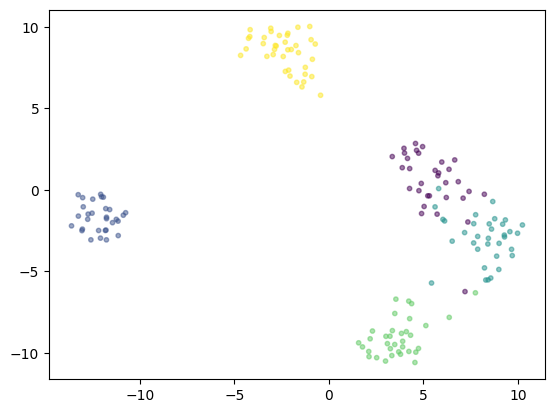

In [70]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [71]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=3402, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [72]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [73]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [74]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

unordered collections
unordered collections


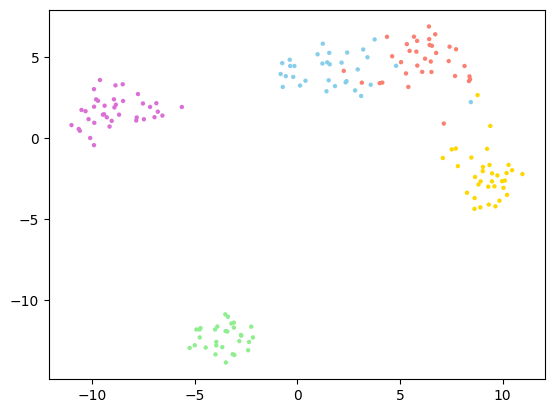

In [75]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


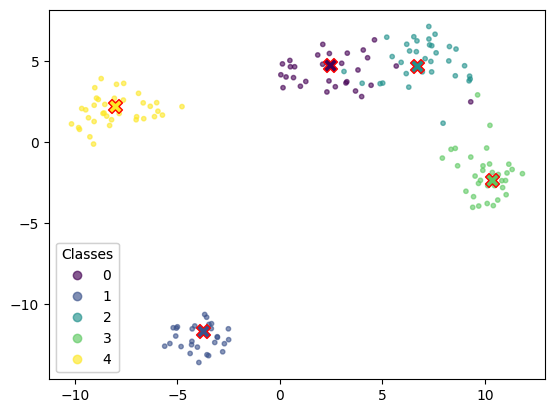

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [77]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [78]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   async wait   async wait
2   concurrency   concurrency
3   time   test order dependency
4   unordered collections   unordered collections
5   test order dependency   test order dependency
6   unordered collections   unordered collections
7   time   async wait
8   time   time
9   concurrency   async wait
10   concurrency   concurrency
11   async wait   unordered collections
2979


12   time   concurrency
13   concurrency   time
14   async wait   async wait
15   time   time
16   concurrency   concurrency
17   time   unordered collections
18   concurrency   async wait
19   unordered collections   unordered collections
20   test order dependency   time
21   unordered collections   unordered collections
22   async wait   async wait
23   time   time
24   async wait   async wait
25   test order dependency   test order dependency
26   time   time
27   unordered collections   unordered collections
28   async wait   async wait
29   concurrency   async wait
30   unordered collections   unordered collections
31   test order dependency   unordered collections
32   async wait   concurrency
33   time   async wait
34   test order dependency   test order dependency
35   concurrency   time
36   unordered collections   unordered collections
37   async wait   concurrency
38   concurrency   concurrency
39   unordered collections   unordered collections
40   async wait   time
41   t

                       precision    recall  f1-score   support

           async wait       0.56      0.50      0.53        10
          concurrency       0.44      0.50      0.47         8
test order dependency       0.50      0.75      0.60         4
                 time       0.44      0.50      0.47         8
unordered collections       1.00      0.75      0.86        12

             accuracy                           0.60        42
            macro avg       0.59      0.60      0.58        42
         weighted avg       0.63      0.60      0.61        42


 - Accuracy :  0.6
 - Precision :  0.63
 - Recall :  0.6
 - F1 score :  0.61
 - MCC :  0.49
 - AUC :  0.75


Perfomnaces by categories



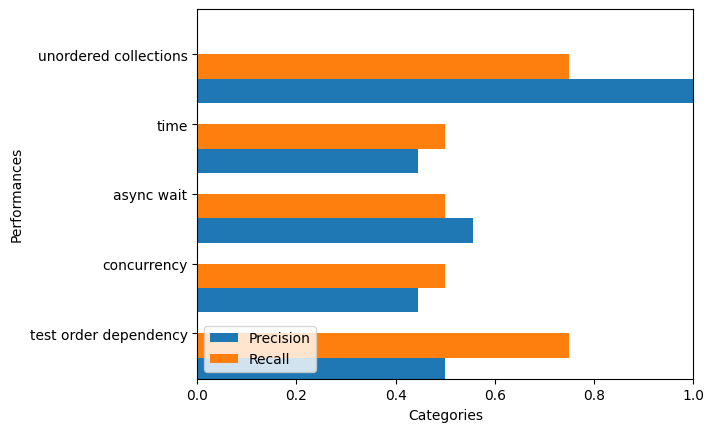



Confusion Matrix 


<AxesSubplot:>

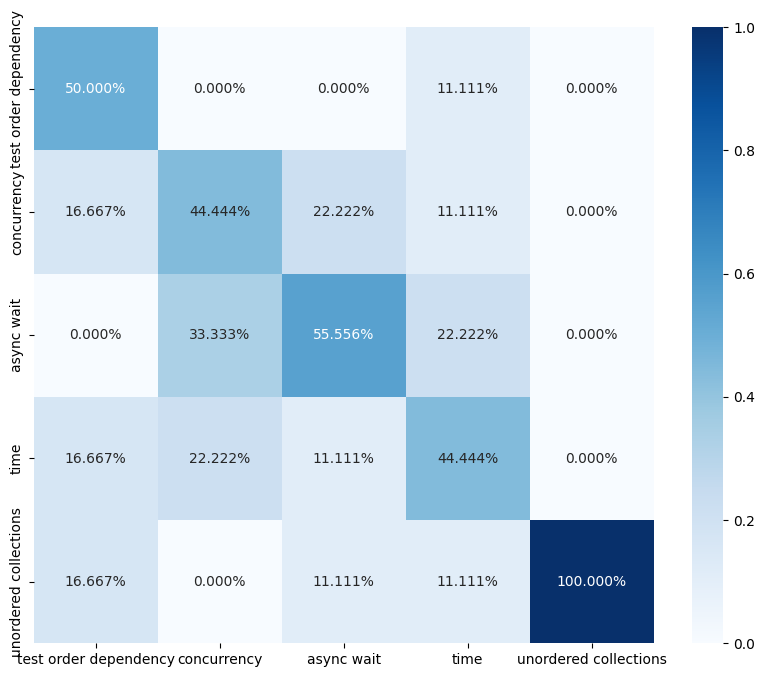

In [79]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

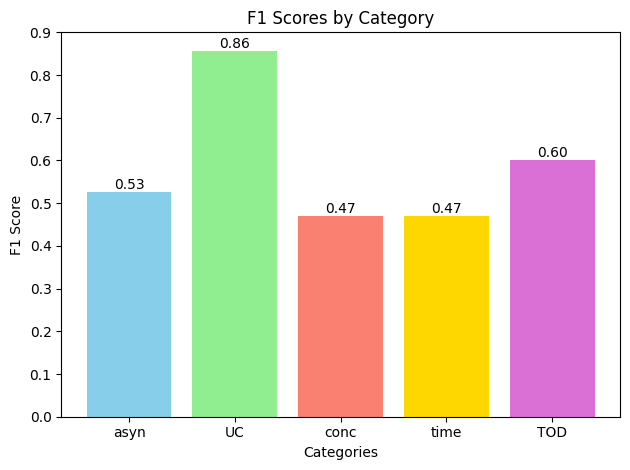

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [81]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [82]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [83]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def extract_projections(siamese_network, dataloader):
    projections = []
    labels = []
    for batch in dataloader:
        label = batch["label"]
        anchor = batch["anchor"]
        projection = siamese_network(anchor)
        
        projections.append(projection.cpu().detach().numpy())
        labels.append(label.numpy())
    projections = np.vstack(projections)
    labels = np.hstack(labels)
    return projections, labels

In [85]:
projections, labels = extract_projections(siamese_network, train_dataloader)
val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

2591
2591
2591
2591
2979


In [86]:
print(len(projections), len(train_dataloader))

168 21


In [87]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(projections, labels)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(projections, labels)

SVC(kernel='linear', random_state=42)

In [88]:
# Evaluate Random Forest Classifier
rf_predictions = rf_classifier.predict(val_projections)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# Evaluate SVM Classifier
svm_predictions = svm_classifier.predict(val_projections)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")

Random Forest Classifier Accuracy: 0.5714285714285714, F1: 0.5828331332533013
SVM Classifier Accuracy: 0.5714285714285714, F1:0.5821528611444577
